In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [26]:
to_df = {'episode': [], 'scene': [], 'character': [], 'line': []}
current_episode = ''
current_scene = ''
scene_count = 0
with open('data/all_scripts.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        if line[:2] == '>>':
            current_episode = line.replace('>>', '')
            scene_count = 0
        elif line[:1] == '>':
            current_scene = line.replace('>', '') + '_' + str(scence_count)
            scene_count += 1
        else:
            speaker, quote = line.split(':', 1)
            if speaker not in set(['All', 'Together']):
                to_df['character'].append(speaker)
                to_df['episode'].append(current_episode)
                to_df['scene'].append(current_scene)
                to_df['line'].append(quote)
df = pd.DataFrame(to_df)
df_scene_count = df.copy()
df_scene_count['season'] = df['episode'].str.split()
df_scene_count['season'] = df_scene_count['season'].apply(lambda x: int(x[1]))
df_scene_count = df_scene_count.groupby(['season', 'episode'])['scene'].count()
df_scene_count = df_scene_count.reset_index()
df_scene_count = df_scene_count.groupby('season')['scene'].sum()
df_scene_count = df_scene_count.reset_index().rename(columns={'scene': 'scene_count'})
df_scene_count.head()

,season,scene_count
0,1,4126
1,2,5223
2,3,5028
3,4,5596
4,5,4829


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [63]:
characters = df.groupby('character')['line'].count()
characters = characters[characters >= 90].reset_index()
characters = characters['character'].to_list()
characters.remove('Man')
recurrent_characters = characters
len(characters)

19

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [48]:
df_clean = df.copy()
reg = "|\\".join(EXCLUDE_CHARS)
df_clean['line'] = df_clean['line'].str.replace(reg, ' ', regex=True).str.lower()
df_clean.head()

,episode,scene,character,line
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Sheldon,so if a photon is directed through a plane wi...
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Leonard,agreed what s your point
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Sheldon,there s no point i just think it s a good id...
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Leonard,excuse me
4,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Receptionist,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

<AxesSubplot:ylabel='Frequency'>

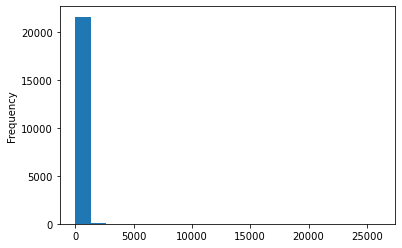

In [62]:
words = df_clean['line'].str.split(expand=True)
word_counts = words.stack().value_counts()
word_counts.plot.hist(bins=20)
# log-log scale (power law)

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [68]:
df_most_speak = df[df['character'].isin(recurrent_characters)]
df_most_speak['word_count'] = df_most_speak['line'].str.split().apply(len)
df_most_speak.groupby('character')['word_count'].sum().sort_values(ascending=False)

/var/folders/10/_7nfqv556wvd8gm4wp6z338h0000gn/T/ipykernel_9760/4003793688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_most_speak['word_count'] = df_most_speak['line'].str.split().apply(len)


character
Sheldon         174911
Leonard          95608
Penny            74247
Howard           64988
Raj              56390
Amy              37384
Bernadette       25810
Stuart            7407
Mrs Cooper        3205
Beverley          1918
Priya             1824
Wil               1577
Emily             1472
Mrs Wolowitz      1364
Arthur            1353
Zack              1336
Leslie            1164
Kripke            1163
Bert              1065
Name: word_count, dtype: int64

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high. Leonard also suspects that it's easier for Sheldon to distinguish the lines that _aren't_ his, rather than those that _are_. We want you to put on the (proverbial) detective's hat and to investigate this claim.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons. Each of your data points (which is one row of your matrix) is one **dialogue line**. Now, use the scikit-learn class **TfIdfVectorizer** to create TF-IDF representations for the data points in your training and test sets. Note that since you're going to train a machine learning model, everything used in the training needs to be independent of the test set. As a preprocessing step, remove stopwords and words that appear only once from your vocabulary. Use the simple tokenizer provided in `helpers/helper_functions.py` as an input to the TfidfVectorizer class, and use the words provided in `helpers/stopwords.txt` as your stopwords.

In [83]:
df_season = df_clean.copy()
df_season['season'] = df['episode'].str.split()
df_season['season'] = df_season['season'].apply(lambda x: int(x[1]))
df_train = df_season[df_season['season'] <= 8]
df_test = df_season[df_season['season'] > 8]

In [84]:
with open('helpers/stopwords.txt', 'r') as f:
    stopwords = [a.replace('\n', '') for a in f.readlines()]
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [87]:
only_once = df_clean['line'].str.split(expand=True).stack().value_counts()
only_once = list(only_once[only_once == 1].index)
only_once

['wocket',
 'slower',
 'itching',
 'bwagging',
 'provisional',
 'remarried',
 'twenties',
 'plopped',
 'complimenting',
 'diss',
 'wucky',
 'rot',
 'enthusiasm',
 'leaked',
 'crisp',
 'kringle',
 'flatworms',
 'workable',
 'airflow',
 'facilitate',
 'ticks',
 'issue…',
 'conically',
 'flashing',
 'shnerpf',
 'uncharted',
 'adhering',
 'electronics',
 'thorne',
 'perpetuate',
 'commies',
 'invoked',
 'jaywalked',
 'camped',
 'deployability',
 'maniac',
 'mated',
 'overcrowding',
 'doted',
 'specialized',
 'dawning',
 'soufflé',
 'snitch',
 'jaywalk',
 'cad',
 'chocula',
 'bernardino',
 'racking',
 'prototypes',
 'applicator',
 'trix',
 'restricting',
 'samantha',
 'reintroduce',
 'wheeler',
 'tools…',
 'pinholes',
 'kip',
 'laughable',
 'defense…',
 'bwiwiant',
 'consoling',
 'buckew',
 'revert',
 'headlights',
 'neanderthals',
 'abusing',
 'creeds',
 'galvanized',
 'cryostat',
 'excuses',
 'denigrated',
 'cob',
 'lumber',
 'emasculating',
 'recollections',
 'modeling',
 'toothbrushes',

In [88]:
df_train['line_preprocessed'] = df_train['line'].apply(lambda x: ' '.join([a for a in x.split() if a not in stopwords and a not in only_once]))
df_train.head()

/var/folders/10/_7nfqv556wvd8gm4wp6z338h0000gn/T/ipykernel_9760/3417426632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['line_preprocessed'] = df_train['line'].apply(lambda x: ' '.join([a for a in x.split() if a not in stopwords and a not in only_once]))


,episode,scene,character,line,season,line_preprocessed
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Sheldon,so if a photon is directed through a plane wi...,1,photon directed plane two slits either slit ob...
1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Leonard,agreed what s your point,1,agreed point
2,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Sheldon,there s no point i just think it s a good id...,1,point think good idea tee shirt
3,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Leonard,excuse me,1,excuse
4,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank._0,Receptionist,hang on,1,hang


In [94]:
vect = TfidfVectorizer(stop_words=stopwords, min_df=2, tokenizer=simple_tokeniser)
train_vect = vect.fit_transform(df_train['line'])
test_vect = vect.transform(df_test['line'])

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [101]:
df_sheldon = df_train[df_train['character'] == 'Sheldon']
sheldon_words = set(df_sheldon['line'].str.split(expand=True).stack().value_counts().index)

df_non_sheldon = df_train[df_train['character'] != 'Sheldon']
non_sheldon_words = set(df_non_sheldon['line'].str.split(expand=True).stack().value_counts().index)

unique_sheldon = sheldon_words - non_sheldon_words

In [102]:
unique_sheldon

{'semantically',
 'exhaustion',
 'interdepartmental',
 'phosphorous',
 'neutrons',
 'universality',
 'factoring',
 'weltschmerz',
 'clan',
 'azure',
 'influenza',
 'satay',
 'caption',
 'baker',
 'wha',
 'neodymium',
 'hungarians',
 'absentmindedly',
 'evidently',
 'tangential',
 'caress',
 'newcomer',
 '640',
 'unmitigated',
 'retort',
 'factions',
 'tweeting',
 'territories',
 'aloe',
 'overrated',
 'mango',
 'possession',
 'colonizing',
 'transformed',
 'declined',
 'cohort',
 'pecking',
 'unloading',
 'ambient',
 'irish',
 'worf',
 'lightsaber',
 'inconsolable',
 'regulation',
 'acquaintances',
 'creatures',
 'auspicious',
 'infernal',
 'loomis',
 'experts',
 'playing…',
 'thermodynamics',
 'rarified',
 'advised',
 'frontier',
 'select',
 'conjugal',
 'destruction',
 '67',
 'generous',
 'bowlers',
 'codifies',
 'cousteau',
 'parakeet',
 'overpower',
 'noob',
 'itsy',
 'aligned',
 'buggy',
 'modesty',
 'eliminated',
 'fraternal',
 'fandom',
 'd…',
 'concrete',
 'stu…',
 'tattling',


In [103]:
def predict_sheldon(row):
    for word in row['line'].split():
        if word in unique_sheldon:
            return True
    return False
pred = df_test.apply(predict_sheldon, axis=1)
pred

40264    False
40265    False
40266    False
40267    False
40268    False
         ...  
51180    False
51181     True
51182    False
51183    False
51184    False
Length: 10921, dtype: bool

In [105]:
sum(pred == (df_test['character'] == 'Sheldon'))/len(df_test.index)

0.7820712388975368